# Analyze Stochastic Model Output

Visualize output for a single stochastic model run. Works with the output files from sm_analysis_rewrite.py.

Examine the effect of including $Q_ek$ 

Note: this script copies from plot_temporal_region.py and viz_AMV_comparison.py



In [139]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sys
import cmocean
from tqdm import tqdm

In [140]:
# Import Custom Modules

projpath   = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"

datpath     = projpath + '01_Data/model_output/'
rawpath     = projpath + '01_Data/model_input/'
outpathdat  = datpath + '/proc/'
figpath     = projpath + "02_Figures/20210104/"

sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/")
sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/")

from amv import proc,viz
import scm
import tbx
proc.makedir(figpath)

/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/02_Figures/20210104/ was found!


In [142]:
# User edits


fnames  = ("forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0",
           "forcingflxeof_090pct_SLAB-PIC_eofcorr2_Qek")
#frcname = "forcingflxeof_090pct_SLAB-PIC_eofcorr2_Qek"

n_model = 1
lags    = np.arange(0,37,1)


expnames = ("Stochastic Model","Stochastic Model (with $Q_{ek}$)",)

In [143]:
# Additional Label/Plotting Information (From Stochastic Model Stylesheet)

# # Regional Analysis Setting (NEW, with STG Split)
# Regional Analysis Settings
bbox_SP     = [-60,-15,40,65]
bbox_ST     = [-80,-10,20,40]
bbox_TR     = [-75,-15,10,20]
bbox_NA     = [-80,0 ,0,65]
bbox_NA_new = [-80,0,10,65]
bbox_ST_w   = [-80,-40,20,40]
bbox_ST_e   = [-40,-10,20,40]
regions     = ("SPG","STG","TRO","NAT","NNAT","STGe","STGw")        # Region Names
bboxes      = (bbox_SP,bbox_ST,bbox_TR,bbox_NA,bbox_NA_new,bbox_ST_e,bbox_ST_w) # Bounding Boxes
regionlong  = ("Subpolar","Subtropical","Tropical","North Atlantic","North Atlantic","Subtropical (East)","Subtropical (West)",)
bbcol       = ["Blue","Red","Yellow","Black","Black"]
bbcol       = ["Blue","Red","Yellow","Black","Black","magenta","red"]
bbsty       = ["solid","dashed","solid","dotted","dotted","dashed","dotted"]

# AMV Pattern Contours
cint        = np.arange(-0.45,0.50,0.05) # Used this for 7/26/2021 Meeting
cl_int      = np.arange(-0.45,0.50,0.05)
bboxplot    = [-80,0,5,60]

# SM Names and colors
modelnames  = ("Constant h","Vary h","Entraining")
mcolors     = ["red","magenta","orange"]

# CESM Names
cesmname    =  ["CESM-FULL","CESM-SLAB"]
cesmcolor   =  ["k","gray"]
cesmline    =  ["dashed","dotted"]

# Autocorrelation Plot parameters
xtk2        = np.arange(0,37,2)
mons3       = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
conf        = 0.95
tails       = 2
alw         = 3

# Power Spectra Options
speccolors = ["r","magenta","Orange","k","gray"]
specnames  = np.hstack([modelnames,cesmname])


# Linear-Power Spectra, < 2-yr
xlm   = [1e-2,5e0]
#xper = np.array([200,100,50,25,10,5,2,1,0.5]) # number of years
xper  = np.array([100,50,20,10,5,2])
xtks  = 1/xper
xlm   = [xtks[0],xtks[-1]]

In [144]:
# Load some additional datasets from CESM for comparison


# Load lat/lon regional
# Get one of the outputs
ldname = "%sstoch_output_%s.npz" % (datpath,frcname)
ld     = np.load(ldname,allow_pickle=True)
lon    = ld['lon']
lat    = ld['lat']

## SST Autocorrelation

In [145]:
# Load CESM1 Data

# Load data for CESM1-PIC
cesmacs= []
expid      = "CESM1-PIC"
rsst_fn    = "%s/proc/SST_Region_Autocorrelation_%s_ensorem0.npz" % (datpath,expid)
ldc        = np.load(rsst_fn,allow_pickle=True)
cesmacs    = ldc['autocorr_region'].item() # Forcing x Region x Model

# Caclulate Conf
# CESM1
cfcesm = np.zeros((len(regions),2,len(lags),2)) # [Region x Model x Lag x Upper/Lower]
ns     = [1798,898]
for rid in range(len(regions)):
    for mid in range(2):
        inac                = cesmacs[rid][mid]
        cfs                 = proc.calc_conflag(inac,conf,tails,ns[mid])
        cfcesm[rid,mid,:,:] = cfs.copy()

/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/proc.py:1389: RuntimeWarning: divide by zero encountered in double_scalars
  zprime = 0.5*np.log((1+rho)/(1-rho))


In [219]:
# Load stochastic model experiments





Pulling just 1 model for Qek runs


In [225]:
def sm_unpacker(invar):
    """
    Unpack stochastic model output
    
        Autocorr = [regions][model][lag]
    """
    
    nregions = len(invar)
    nmodels  = len(invar[0])
    nother   = len(invar[0][0])
    print("Found... Regions (%i) ; Models (%i) ; Otherdims (%i)" % (nregions,nmodels,nother))
    unpacked = np.zeros((nregions,nmodels,nother)) * np.nan
    
    for r in range(nregions):
        for m in range(nmodels):
            unpacked[r,m,:] = invar[r][m]
    return unpacked
    
# Test
#up = sm_unpacker(sstac)    
#up.shape

In [221]:
kmonths

{0: 2, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}

In [229]:
# Load for stochastic model experiments (select a given model)


sstacs  = []
kmonths = []
for i in range(len(fnames)): 
    
    expid   = fnames[i]
    if "Qek" in expid:
        mid = 0
        print("Pulling just 1 model for Qek runs")
    else:
        mid = 2
    
    # Load the dictionary [h-const, h-vary, entrain]
    
    rsst_fn = "%sproc/SST_Region_Autocorrelation_%s.npz" % (datpath,expid)
    ld      = np.load(rsst_fn,allow_pickle=True)#.item()
    sstac   = ld['autocorr_region'].item() # I think its [region][model][lag]
    kmonth  = ld['kmonths'].item()
    
    sstup = sm_unpacker(sstac)
    sstacs.append(sstup[:,mid,:])
    
sstacs = np.array(sstacs) # [forcing x region x lag]
kmonths = kmonth

# Calculate Conf
cfstoch = np.zeros([len(fnames),len(regions),len(lags),2]) # [Forcing x  Region x Lag x Upper/Lower]
n       = 1000
for fid in range(len(fnames)):# Loop by forcing
    for rid in range(len(regions)): # Loop by Region
        inac                   = sstacs[fid,rid,:]
        cfs                    = proc.calc_conflag(inac,conf,tails,n)
        cfstoch[fid,rid,:,:] = cfs.copy()
        
        
"""
Key Outputs

kmonths [Region]
sstacs  [Forcing x Region x Lag]
cfstoch [Forcing x Region x Lag x Upper/Lower]
"""
print(len(kmonths))
print(sstacs.shape)
print(cfstoch.shape)

Found... Regions (7) ; Models (3) ; Otherdims (37)
Pulling just 1 model for Qek runs
Found... Regions (7) ; Models (1) ; Otherdims (37)
7
(2, 7, 37)
(2, 7, 37, 2)


/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/proc.py:1389: RuntimeWarning: divide by zero encountered in double_scalars
  zprime = 0.5*np.log((1+rho)/(1-rho))


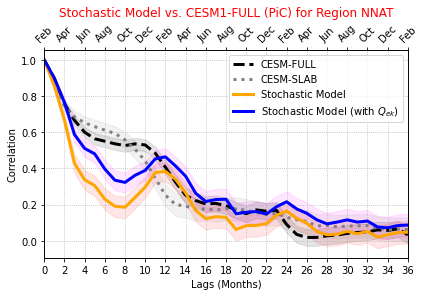

In [269]:
# Plot Autocorrelation
rid     = 4

fig,ax = plt.subplots(1,1,figsize=(6,4))
kmonth = kmonths[rid]


title  = "Stochastic Model vs. CESM1-FULL (PiC) for Region %s" % (regions[rid])

ax,ax2 = viz.init_acplot(kmonth,xtk2,lags,ax=ax,title="")
ax.set_title(title,color=bbcol[fid],fontsize=12)


for cid in range(2):
        ax.plot(lags,cesmacs[rid][cid],color=cesmcolor[cid],label=cesmname[cid],ls=cesmline[cid],lw=alw)
        ax.fill_between(lags,cfcesm[rid,cid,lags,0],cfcesm[rid,cid,lags,1],
                        color=cesmcolor[cid],alpha=0.10)

for fid in range(len(fnames)):
    ax.plot(lags,sstacs[fid,rid],color=speccolors[fid],label=expnames[fid],lw=alw)
    ax.fill_between(lags,cfstoch[fid,rid,lags,0],cfstoch[fid,rid,lags,1],
                    color=mcolors[fid],alpha=0.10)

ax.legend()

plt.savefig("%sAutocorrelation_region%s_Qek.png"% (figpath,regions[rid]),dpi=200)

## Plot the AMV Pattern

In [233]:
# Load CESM Data

# Load data for CESM1-PIC
expid      = "CESM1-PIC"
rsst_fn    = "%s/proc/AMV_Region_%s_ensorem0.npz" % (datpath,expid)
ldc        = np.load(rsst_fn,allow_pickle=True)
cesmpat = ldc['amvpat_region'].item()
cesmidx = ldc['amvidx_region'].item()

In [71]:
# Load Stochastic Model Data

# Load for stochastic model experiments
amvpats  = []
amvids   = []

# Load the dictionary [h-const, h-vary, entrain]
expid = frcname
rsst_fn = "%sproc/AMV_Region_%s.npz" % (datpath,expid)
print("Loading %s" % rsst_fn)
ld = np.load(rsst_fn,allow_pickle=True)#.item()

amvidx = ld['amvidx_region'].item()
amvpat = ld['amvpat_region'].item()

amvpats.append(amvpat)
amvids.append(amvidx)

Loading /Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_output/proc/AMV_Region_forcingflxeof_090pct_SLAB-PIC_eofcorr2_Qek.npz


In [236]:
len(amvpats[0][0])

1

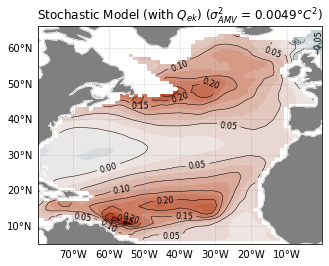

In [90]:
# Plot AMV Pattern

#rid = 4
#mid = 0
f = 0
plotbbox=False
dfcol = 'w'


cmax  = 0.5
cstep = 0.025
lstep = 0.05
cint,cl_int=viz.return_clevels(cmax,cstep,lstep)
clb = ["%.2f"%i for i in cint[::4]]



fig,ax = plt.subplots(1,1,subplot_kw = {'projection':ccrs.PlateCarree()})

# Make the Plot
ax = viz.add_coast_grid(ax,bboxplot,line_color=dfcol,
                        fill_color='gray')

pcm = ax.contourf(lon,lat,amvpats[f][rid][mid].T,levels=cint,cmap=cmocean.cm.balance)
ax.pcolormesh(lon,lat,amvpats[f][rid][mid].T,vmin=cint[0],vmax=cint[-1],cmap=cmocean.cm.balance,zorder=-1)
cl = ax.contour(lon,lat,amvpats[f][rid][mid].T,levels=cl_int,colors="k",linewidths=0.5)
ax.clabel(cl,levels=cl_int,fontsize=8)
ax.set_title("%s ($\sigma^2_{AMV}$ = %.4f$\degree C^2$)"%(expnames[mid],np.var(amvids[f][rid][mid])))
if plotbbox:
    ax,ll = viz.plot_box(bbox_NNA,ax=ax,leglab="AMV",
                         color=dfcol,linestyle="dashed",linewidth=2,return_line=True)

plt.savefig("%sAMV_Pattern_Qek.png"%(figpath),dpi=200)


## Now lets plot the spectra...

In [246]:
# Load the necessary data

fname      = frcname
nyrs       = 1000
modelnames = expnames

# Load in SSTs for each region
sstdict = []
for f in range(len(fnames)):
    
    rsst_fn = "%s/proc/SST_RegionAvg_%s.npy" % (datpath,fnames[f])
    
    if "Qek" in fnames[f]:
        mid = 0
        print("Pulling just 1 model for Qek runs")
    else:
        mid = 2
    
    sst     = np.load(rsst_fn,allow_pickle=True).item()
    sstup = sm_unpacker(sst)
    sstdict.append(sstup[:,mid,:])
    #sst.shape
sstdict = np.array(sstdict) # [forcing x region x time]
sstdict.shape


# Identify the variance for each region and load in numpy arrays
sstvars = np.var(sstdict,axis=2) # [forcing x region]
sstvars.shape


#% Load corresponding CESM Data ------------------
expid      = "CESM1-PIC"
rsst_fn    = "%s/proc/SST_RegionAvg_%s_ensorem0.npy" % (datpath,expid)
sstcesm    = np.load(rsst_fn,allow_pickle=True).item() # [Region x Model x Time]
cesmname   =  ["CESM-FULL","CESM-SLAB"]

# Make everything into nested lists (very bad hard fix...)
sstall = sstdict



# for i in range(len(fnames)): # Forcings + 2 CESM1 configs
#     if i < len(fnames):
#         sstall.append(sstdict[i,...])
#     else:
#         sstall.append(sstcesm)
# # Identify the variance for each region and load in numpy arrays
# sstvarscesm = np.zeros((len(regions),2)) # Forcing x Region x Model
# print(sstvarscesm.shape)

# for rid in range(len(regions)-1):
#     for model in range(len(cesmname)):
#         sstin  = sstcesm[rid][model]
#         print(sstin.shape)
#         sstvar = np.var(sstin)
#         print("Variance for region %s, model %s is %f" % (regions[rid],cesmname[model],sstvar))
#         sstvarscesm[rid,model]   = sstvar


"""
Key Outputs

Stochastic Model --- --- 
sstdict [forcing x region x time]
sstvars [forcing x region]


CESM




Combined




"""

Found... Regions (7) ; Models (3) ; Otherdims (12000)
Pulling just 1 model for Qek runs
Found... Regions (7) ; Models (1) ; Otherdims (12000)


'\nKey Outputs\n\nStochastic Model --- --- \nsstdict [forcing x region x time]\nsstvars [forcing x region]\n\n\nCESM\n\n\n\n\nCombined\n\n\n\n\n'

In [247]:
# Calculate the spectra

ssmooth    = 65
cnsmooths  = [75,65]
pct        = 0.10
nsmooth    = np.concatenate([np.ones(3)*ssmooth,np.ones(2)*cnsmooths])
smoothname = "smth-obs%03i-full%02i-slab%02i" % (ssmooth,cnsmooths[0],cnsmooths[1])

pct     = 0.10
dofs    = [1000,1000,898,1798] # In number of years

# Loop for each region
ss = []
ff = []
cc = []
bb = []
vv = []
for rid in range(len(regions)):
    
    # Get SSTs and mush into 1 list
    insst = []
    for fid in range(len(fnames)):
        # Append each stochastic model result
        insst.append(sstall[fid,rid,:])
    insst.append(sstcesm[rid][0])
    insst.append(sstcesm[rid][1])
    
    # Calculate the variance
    insstvars = []
    for s in insst:
        insstvars.append(np.var(s))
    
    # Calculate Spectra and confidence Intervals
    specs,freqs,CCs,dofs,r1s = scm.quick_spectrum(insst,nsmooth,pct)
    alpha = 0.05
    bnds = []
    for nu in dofs:
        lower,upper = tbx.confid(alpha,nu*2)
        bnds.append([lower,upper])
    
    ss.append(specs)
    ff.append(freqs)
    cc.append(CCs)
    bb.append(bnds)
    vv.append(insstvars)
    
specsall  = ss # array[forcing][region][model]
freqsall  = ff
Cfsall    = cc
bndsall   = bb
sstvarall = vv

In [256]:
specnames

['SM', 'SM ($Q_{ek}$', 'CESM-FULL', 'CESM-SLAB']

Note: I think there was a mislabel. specsall is [region][model] for this case?

In [258]:


#len(ss[0])
len(specsall),len(regions)

#fig,axs = plt.subplots(2,2,figsize=(16,8))
specnames  = ["SM","SM ($Q_{ek}$","CESM-FULL","CESM-SLAB"]
speccolors = ["orange","blue","black","gray"]

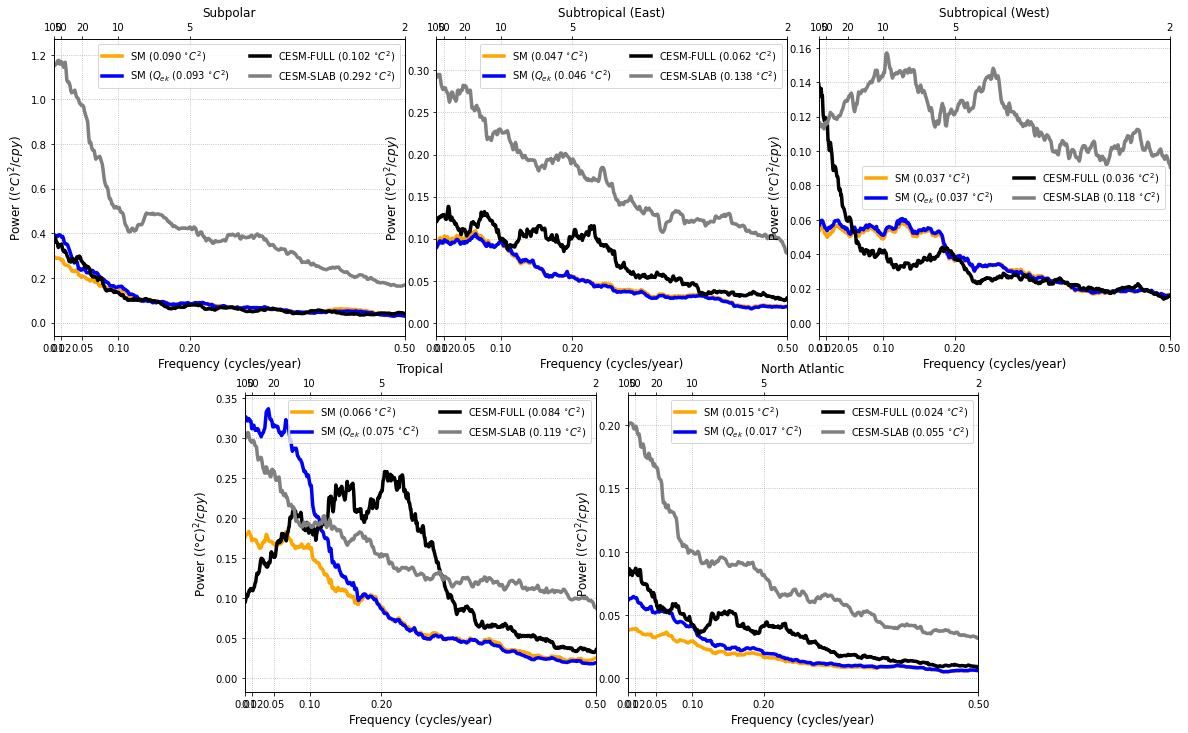

In [260]:
rid_sel = [0,5,6,2,4]
fig,axs = viz.init_2rowodd(3, proj=None,figsize=(20,12))

for r in range(len(rid_sel)):
    ax     = axs[r]
    rid    = rid_sel[r]
    kmonth = kmonths[r]
    
    speclabels = ["%s (%.3f $^{\circ}C^2$)" % (specnames[i],sstvarall[rid][i]) for i in range(len(insst)) ]
    ax    = axs[r]
    ax,ax2 = viz.plot_freqlin(specsall[rid],freqsall[rid],speclabels,speccolors,
                         ax=ax,plottitle=regionlong[rid],xlm=xlm,xtick=xtks,return_ax2=True,lw=3.5)
    title  = "%s (Lag 0 = %s)" % (regionlong[rid],mons3[kmonth])
    
    
    #ax.set_title(title)
    
plt.savefig("%sSpectra_Qek_Comparison.png"%(figpath),dpi=200)
    

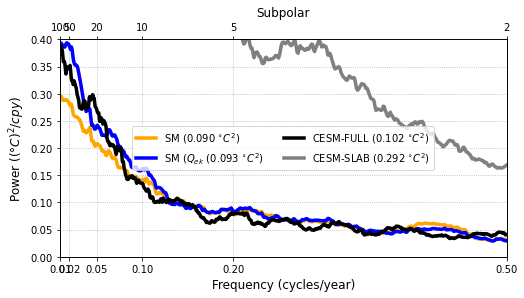

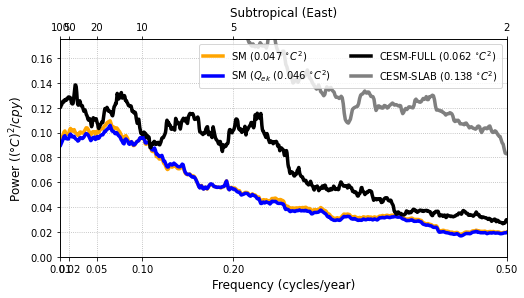

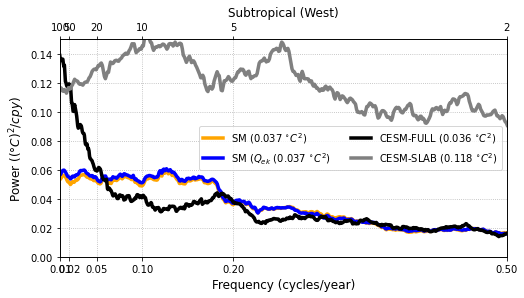

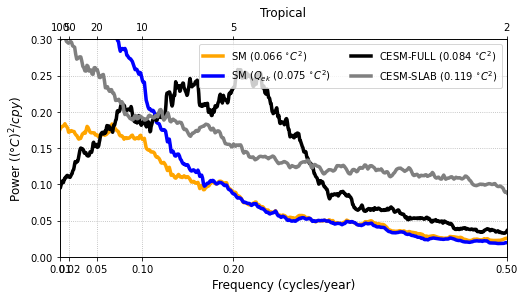

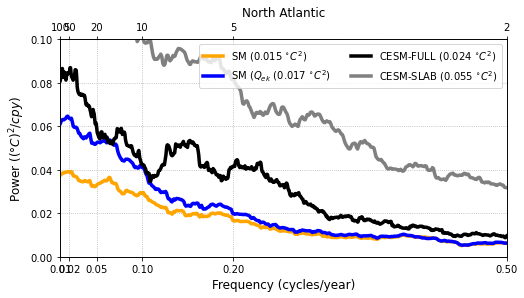

In [266]:
# Plot separately
rid_sel = [0,5,6,2,4]
#fig,axs = viz.init_2rowodd(3, proj=None,figsize=(20,12))

for r in range(len(rid_sel)):
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    rid    = rid_sel[r]
    kmonth = kmonths[r]
    
    
        
    
    speclabels = ["%s (%.3f $^{\circ}C^2$)" % (specnames[i],sstvarall[rid][i]) for i in range(len(insst)) ]
    ax,ax2 = viz.plot_freqlin(specsall[rid],freqsall[rid],speclabels,speccolors,
                         ax=ax,plottitle=regionlong[rid],xlm=xlm,xtick=xtks,return_ax2=True,lw=3.5)
    title  = "%s (Lag 0 = %s)" % (regionlong[rid],mons3[kmonth])
    
    if r == 0:
        ax.set_ylim([0,0.4])
    elif r == 1:
        ax.set_ylim([0,0.175])
    elif r == 2:
        ax.set_ylim([0,0.15])
    elif r == 3:
        ax.set_ylim([0,0.30])
    elif r == 4:
        ax.set_ylim([0,0.1])
    #ax.set_title(title)
    plt.savefig("%sSpectra_Qek_Comparison_region%s.png"%(figpath,regions[r]),dpi=200)

#plt.savefig("%sSpectra_Qek_Comparison.png"%(figpath),dpi=200)
    

  0%|                                                     | 0/1 [00:00<?, ?it/s]/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/viz.py:732: RuntimeWarning: divide by zero encountered in double_scalars
  xtkl = ["%.1f" % (1/x) for x in xtick]
/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/viz.py:925: RuntimeWarning: divide by zero encountered in double_scalars
  xtkl   = ["%i" % (1/x) for x in xtick2]
  0%|                                                     | 0/1 [00:00<?, ?it/s]


OverflowError: cannot convert float infinity to integer

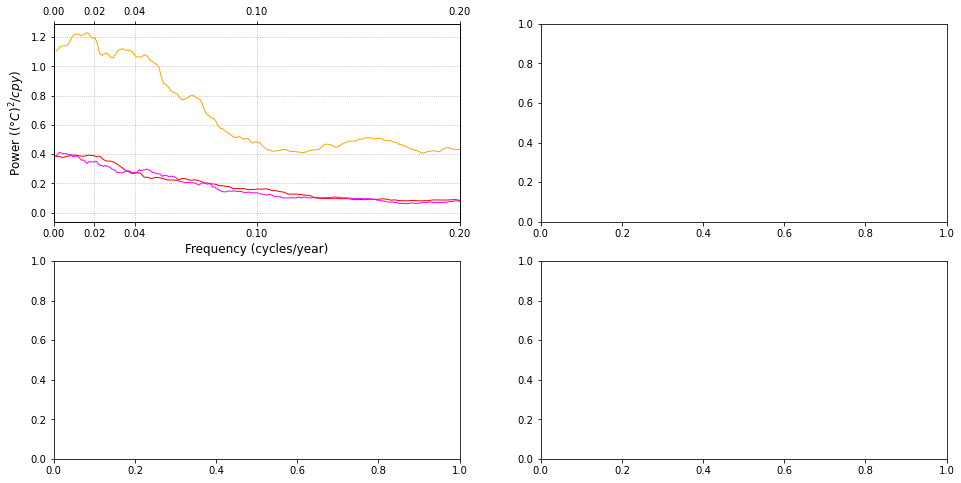

In [108]:
fig,axs = viz.init_2rowodd(3, proj=None,figsize=(14,6))
    for r in range(len(rid_sel)):
                      
        rid = rid_sel[r]
        ax = axs[r]
        kmonth = kmonths[f][rid]
        
        
        # Plot some differences
        title      = "%s (Lag 0 = %s)" % (regionlong[rid],mons3[kmonth])
        ax,ax2 = viz.init_acplot(kmonth,xtk2,lags,ax=ax,title=title)
        #ax.plot(lags,cesmauto2[lags],label="CESM SLAB",color='k')
        #ax.plot(lags,fullauto,color='k',label='CESM Full',ls='dashdot')
        
    
        # Plot Each Model
        for mid in mid_sel:
            ax.plot(lags,sstacs[f][rid][mid],color=mcolors[mid],label=modelnames[mid])
            ax.fill_between(lags,cfstoch[f,rid,mid,lags,0],cfstoch[f,rid,mid,lags,1],
                            color=mcolors[mid],alpha=0.10)
            
        # Plot CESM
        for cid in range(2):
            ax.plot(lags,cesmacs[rid][cid],color=cesmcolor[cid],label=cesmname[cid],ls=cesmline[cid])
            ax.fill_between(lags,cfcesm[rid,cid,lags,0],cfcesm[rid,cid,lags,1],
                            color=cesmcolor[cid],alpha=0.10)
            
        if r == 0:
            ax.legend()
        if r%2 == 1:
            ax.set_ylabel("")
        if r<2:
            ax.set_xlabel("")
    
    title = "SST Autocorrelation (Forcing = 90 perc. Variance [%s])" % (frcnamelong[f])
    plt.suptitle(title,y=1.02)
    savename = "%sSST_Autocorrelation_Comparison_%s.png" % (figpath,fnames[f])
    plt.savefig(savename,dpi=150,bbox_inches='tight')

In [105]:
sstvarall

[[0.09277567363958898, 0.10188892919596593, 0.29162910308303297],
 [0.020455017028426097, 0.025569828926221054, 0.07189075732831006],
 [0.07498153059365088, 0.08438848080417284, 0.11917259175263557],
 [0.016455990523036295, 0.021835520666129524, 0.04356712571297327],
 [0.017242615368613025, 0.024004620077176905, 0.05463397260129842],
 [0.04578494364583842, 0.06243830508720442, 0.138288200244269],
 [0.036793658254570955, 0.035818408911228075, 0.11828365240320868]]